# PARAMETER ESTIMATION WITHIN MARKOV CHAIN MONTE CARLO.

# 1. BAYESIAN LINEAR REGRESSION

In [1]:
#import requred modules
%matplotlib inline
from pymc3 import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import matplotlib.pyplot as pl
import emcee


/home/maslinux/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Generating data  and scatter plot.
#create a regression line defined by intercept and slope 
#and add data points by sampling from a Normal with the mean set to the regression line
size = 200
true_intercept = 1
true_slope = 2
x = np.linspace(0,1,size)
#y=a+bx
true_regression_line = true_intercept + true_slope*x
y = true_regression_line + np.random.normal(scale = 0.5, size = size)
data = dict(x=x,y=y)

In [3]:
data

{'x': array([0.        , 0.00502513, 0.01005025, 0.01507538, 0.0201005 ,
        0.02512563, 0.03015075, 0.03517588, 0.04020101, 0.04522613,
        0.05025126, 0.05527638, 0.06030151, 0.06532663, 0.07035176,
        0.07537688, 0.08040201, 0.08542714, 0.09045226, 0.09547739,
        0.10050251, 0.10552764, 0.11055276, 0.11557789, 0.12060302,
        0.12562814, 0.13065327, 0.13567839, 0.14070352, 0.14572864,
        0.15075377, 0.15577889, 0.16080402, 0.16582915, 0.17085427,
        0.1758794 , 0.18090452, 0.18592965, 0.19095477, 0.1959799 ,
        0.20100503, 0.20603015, 0.21105528, 0.2160804 , 0.22110553,
        0.22613065, 0.23115578, 0.2361809 , 0.24120603, 0.24623116,
        0.25125628, 0.25628141, 0.26130653, 0.26633166, 0.27135678,
        0.27638191, 0.28140704, 0.28643216, 0.29145729, 0.29648241,
        0.30150754, 0.30653266, 0.31155779, 0.31658291, 0.32160804,
        0.32663317, 0.33165829, 0.33668342, 0.34170854, 0.34673367,
        0.35175879, 0.35678392, 0.36180905,

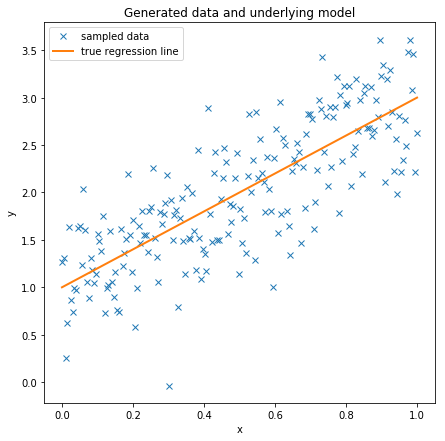

In [4]:
#111 means 1*1 grid

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [5]:
#Estimating the model
#fitting a bayesian linear regression model to this data

with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    
    
   # Define priors
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('Intercept', 0, sd=20)
    x_coeff = Normal('x', 0, sd=20)
    
    # Define likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x, 
                        sd=sigma, observed=y)
    
    # Inference!
    trace = sample(progressbar=False) # draw posterior samples using NUTS sampling


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x, Intercept, sigma]


In [6]:
#Alternative fromulation using GLM formulas

In [7]:
with Model() as model:
#specify glm and pass in data. The resulting linear model, it's likelihood and all 
#its parameters are automatically added to our model.
#glm() parses the Patsy model string, adds random variables for each 
#regressor (Intercept and slope x in this case), adds a likelihood (by default, a Normal
#is chosen), and all other variables (sigma). Finally, glm() then initializes the parameters to a good starting point by estimating a frequentist linear model using statsmodels..

    GLM.from_formula('y ~ x', data)
    trace = sample(progressbar=False, tune=1000, njobs=4)
#draw posterior samples using NUTS sampling
#No U-Turn Sampler (NUTS) is a Hamiltonian Monte Carlo Method. This means that it is not
#a Markov Chain method and thus, this algorithm avoids the random walk part, 
#which is often deemed as inefficient and slow to converge.
#Instead of doing the random walk, NUTS does jumps of length x.
#Each jump doubles as the algorithm continues to run. This happens until the trajectory 
# reaches a point where it wants to return to the starting point.
#'y ~ x' specifies that we have an output variable y that we want to estimate as a 
#linear function of x.
#

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]


In [8]:
trace

<MultiTrace: 4 chains, 500 iterations, 4 variables>

In [9]:
traceplot?

/home/maslinux/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


<Figure size 504x504 with 0 Axes>

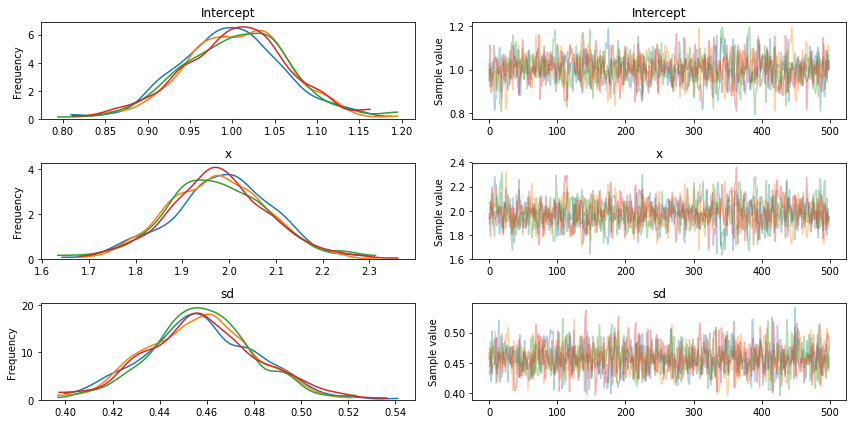

In [10]:
# Analyzing the model
plt.figure(figsize=(7,7))
traceplot(trace)
plt.tight_layout()

In [11]:
#There  are two plots for each parameter. The right plot is called a trace plot – it shows 
#the values the parameter took during the runtime of the chain. 
#The left plot is called a marginal density plot. Basically, it is the (smoothened) 
#histogram of the values in the trace-plot. It shows our marginal posterior  for each 
#parameter value on the x-axis we get a probability on the y-axis that tells us how likely 
#that parameter value is.
#A couple of things to see here. The first is that our sampling chains for the individual 
#parameters (left side) seem well converged and stationary (there are no large drifts or 
#other odd patterns). We see 4 lines because we ran 4 chains in parallel (njobsparameter). 
#They all seem to provide the same answer which is re-assuring.

#Secondly, the maximum posterior estimate of each variable (the peak in the left side 
#distributions) is very close to the true parameters used to generate the data 
#(x is the #regression coefficient and sigma is the standard deviation of our normal).



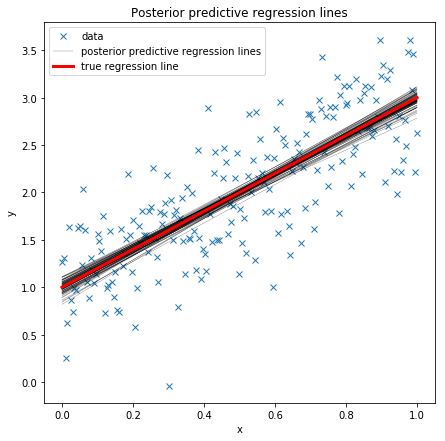

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
plots.plot_posterior_predictive_glm(trace, samples=100, 
                                    label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='r')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

In [13]:
#As you can see, our estimated regression lines are very similar to the true regression line.
#But since we only have limited data we have uncertainty in our estimates, here expressed 
#by the variability of the lines


# 2. NON LINEAR REGRESSION  MODEL

We will consider a multi-dimensional gaussian process

In [14]:
#function that returns the density
#emcee actually requires the logarithm of p. We’ll call it lnprob
def lnprob(x, mu, icov):
    diff = x-mu
    return -np.dot(diff,np.dot(icov,diff))/2.0


In [15]:
# setting specific values of “hyperparameters” in 50 dimensions:
# first argument of probability function is the position of a single walker (a N dimensional numpy array).
#The following arguments are going to be constant every time the function is called and 
#the values come from the args parameter of our EnsembleSampler that we’ll see soon.
ndim = 50

means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov)


In [16]:
# first compute the inverse of cov because that’s what we need in our probability function
icov = np.linalg.inv(cov)

In [17]:
# we will use 250 walkers
#we need to guess a starting point for each of the 250 walkers
# initial guess  250-by-50 array
nwalkers = 250
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [18]:
#The main interface provided by emcee is the EnsembleSampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[means, icov])

In [19]:
#run a few “burn-in” steps in MCMC chain to let the walkers explore the parameter space 
#a bit and get settled into the maximum of the density
#We will run a burn-in of 100 steps
#then save the final position of the walkers (after the 100 steps) to a variable called pos
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [20]:
#Now, we can do our production run of 1000 steps
sampler.run_mcmc(pos, 1000)

(array([[ 0.39501073, -2.31835461, -0.8121484 , ...,  0.68451824,
         -2.50007302,  3.16325991],
        [-0.28454359,  0.09313417,  1.86271754, ..., -0.03699513,
          1.01871321,  2.36098599],
        [-0.51521588, -2.71359306, -0.75272063, ...,  2.99303947,
          1.77420068, -0.76822049],
        ...,
        [-5.10993028,  3.18454591,  4.6666839 , ..., -0.39769929,
          0.45976403,  0.3947977 ],
        [-0.20671286,  1.32637531, -1.73537369, ...,  0.75669835,
         -4.05073637,  0.00659559],
        [ 2.29007222, -1.05901165, -1.51256296, ...,  1.06692125,
         -2.0378196 ,  2.96958496]]),
 array([-32.15300647, -14.98312478, -19.61146335, -26.79361435,
        -23.65759171, -24.97826275, -30.28651406, -24.08935566,
        -25.72001262, -31.67839839, -22.7698272 , -24.98122696,
        -30.841539  , -21.41717831, -24.99309114, -22.11606859,
        -28.89317941, -17.04743585, -21.75607891, -24.25386802,
        -41.97864448, -27.51141045, -22.61044757, -36

In [21]:
#The sampler now has a property EnsembleSampler.chain that is a numpy array with the 
#shape (250, 1000, 50). EnsembleSampler.flatchain has the shape (250000, 50) and contains all the samples reshaped into a flat list. 
#You can see now that we now have 250 000 unbiased samples of the density

/home/maslinux/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


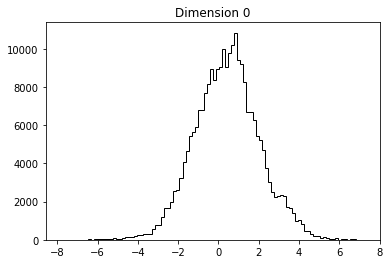

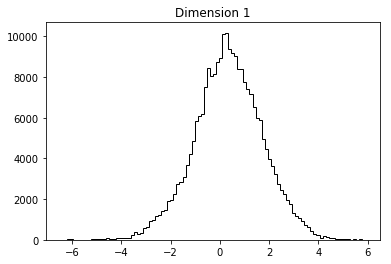

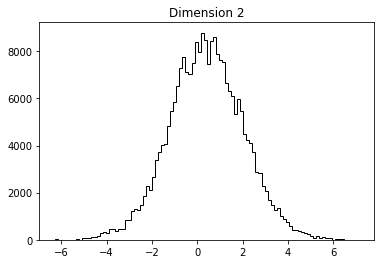

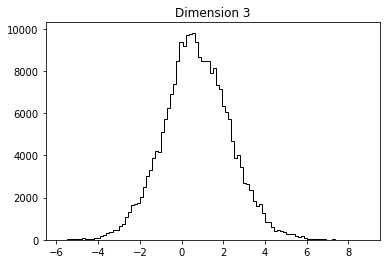

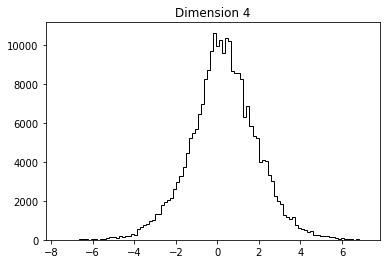

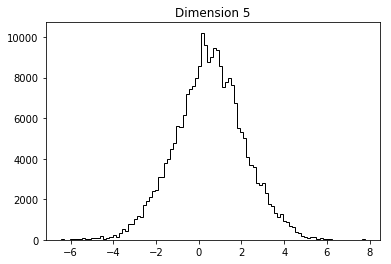

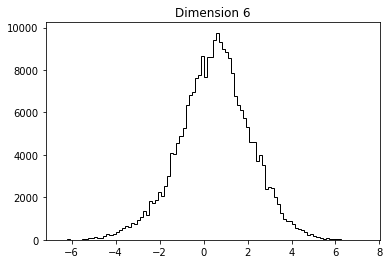

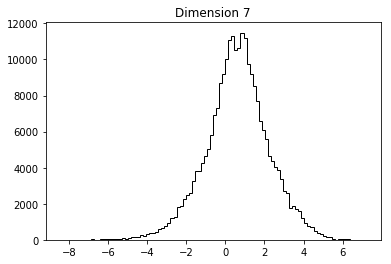

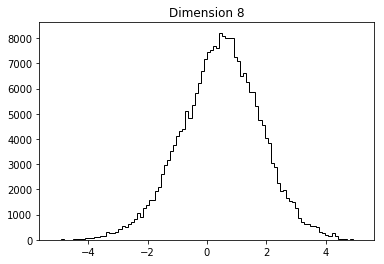

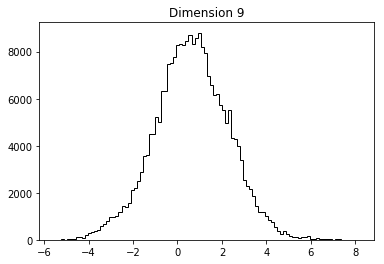

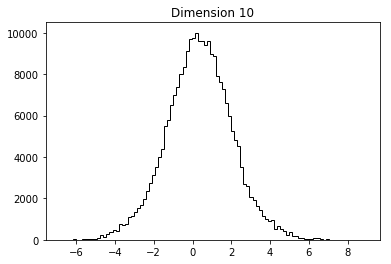

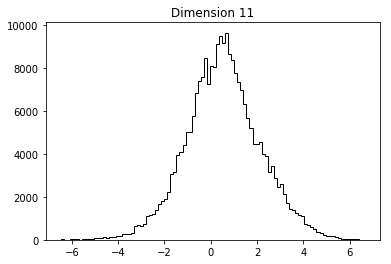

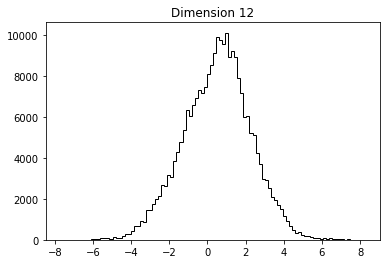

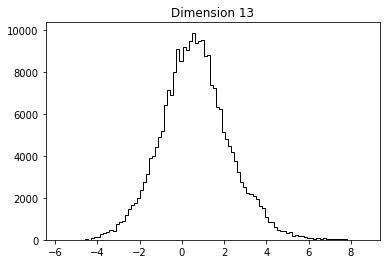

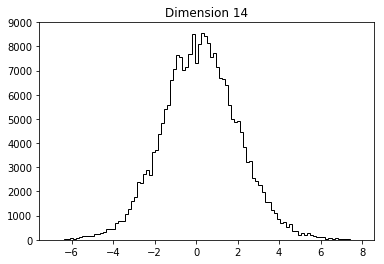

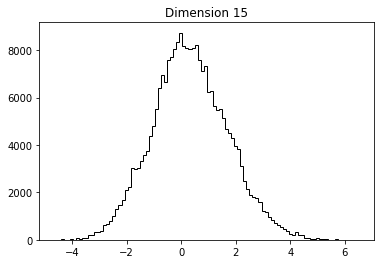

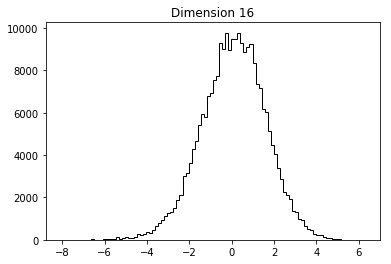

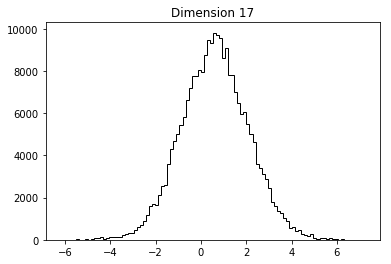

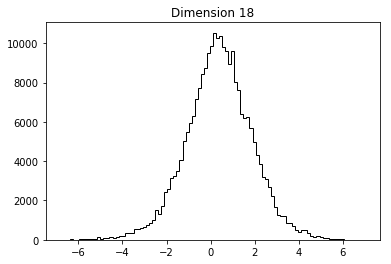

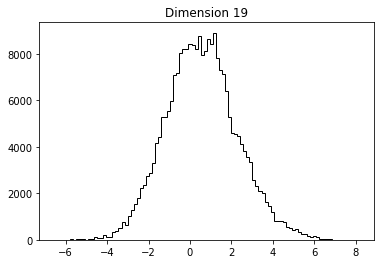

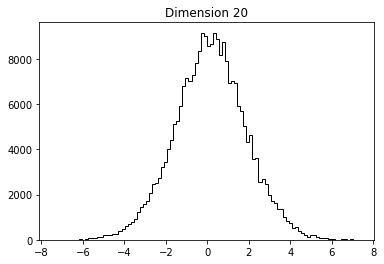

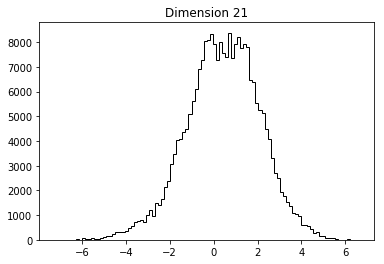

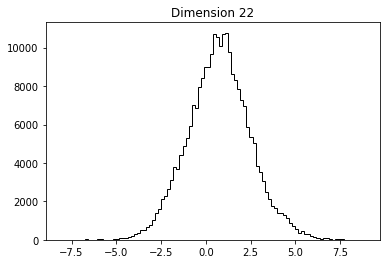

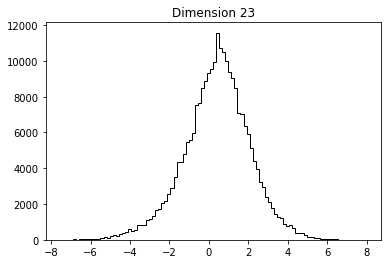

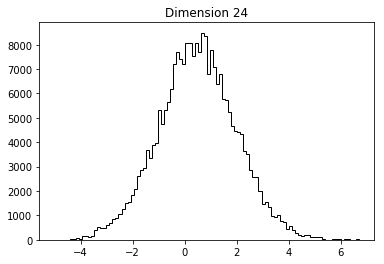

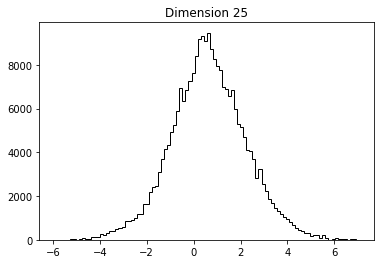

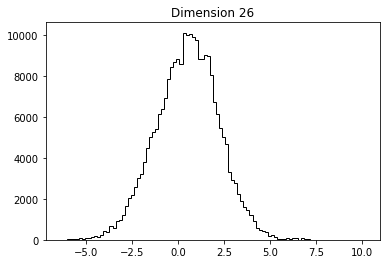

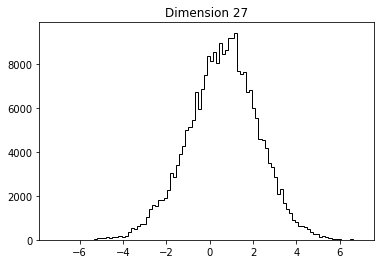

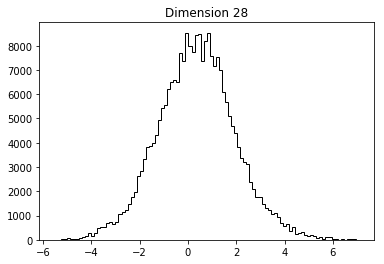

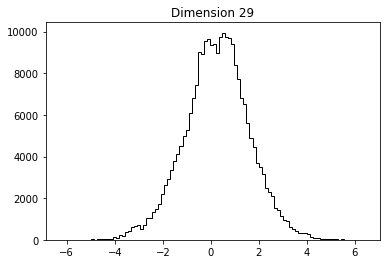

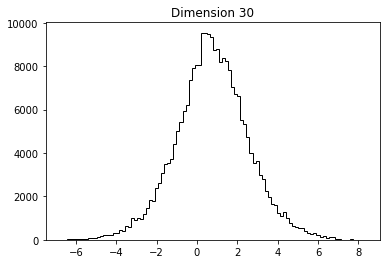

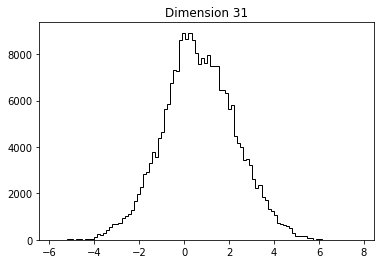

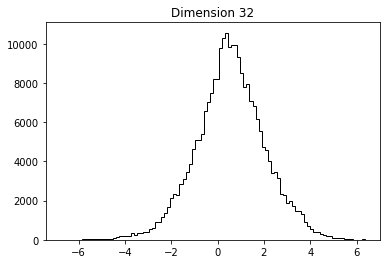

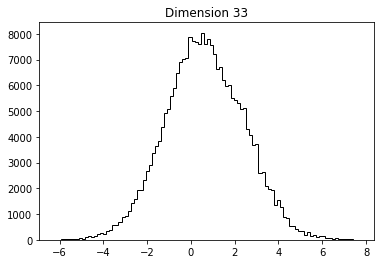

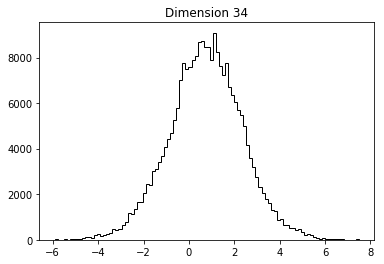

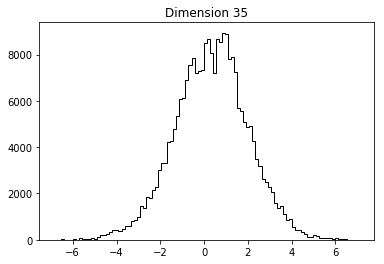

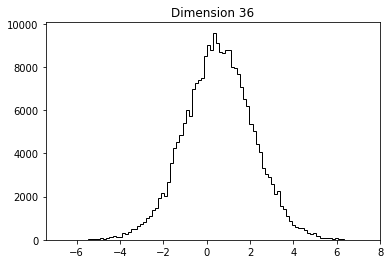

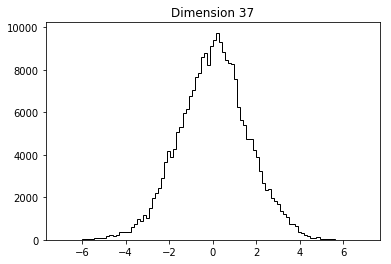

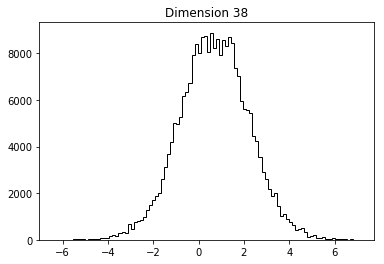

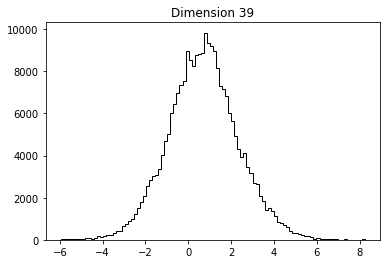

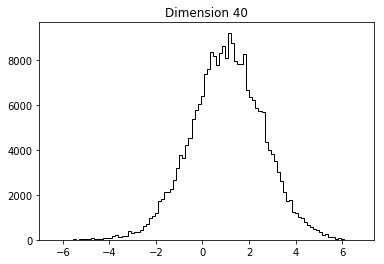

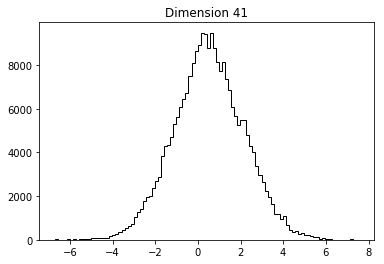

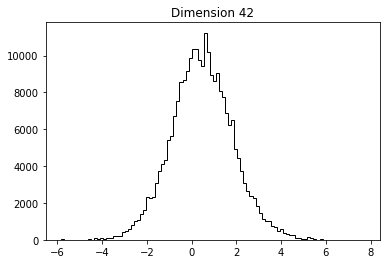

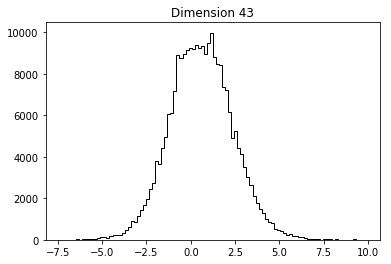

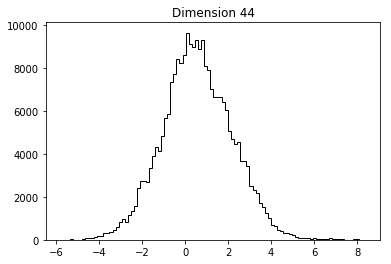

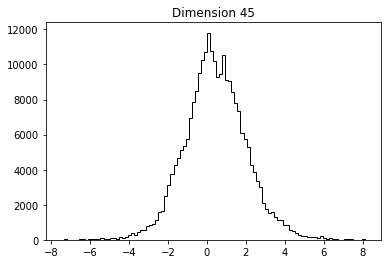

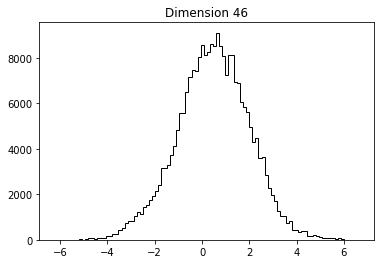

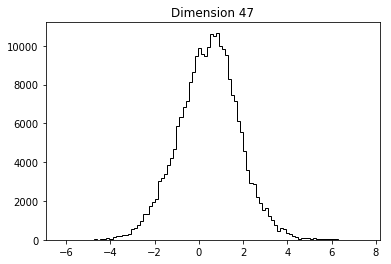

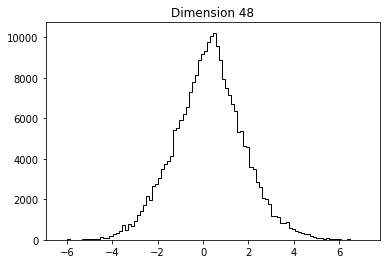

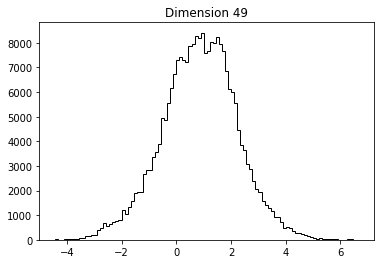

In [22]:
# histograms of samples to get an estimate of the density that we were sampling:


for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

plt.show()

In [23]:
# Another good test of whether or not the sampling went well is to check the mean acceptance
#fraction of the ensemble using the EnsembleSampler.acceptance_fraction() property.
# number should be between approximately 0.25 and 0.5
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.192


# Fitting a line to data when you don’t believe the error bars on your data.

In [24]:
# first step is generally to write down the likelihood function (the probability of a dataset given the model parameters)
#we will consider a linear model where the quoted uncertainties are underestimated by a constant fractional amount
#We will generate a synthetic dataset from this model

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

<ErrorbarContainer object of 3 artists>

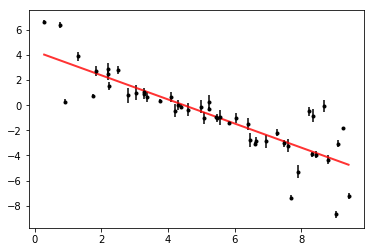

In [25]:
# synthetic dataset (with the underestimated error bars)

xl = np.array([0, 10])
plt.plot(x, m_true*x+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")

In [26]:
#The true model is shown as the red line and the effect of the underestimated uncertainties
#is obvious when you look at this figure. 

In [27]:
#linear least squares
#The standard way to fit a line to these data (assuming independent Gaussian error bars) 
#Appealing because solving for the parameters—and their associated uncertainties is 
#simply a linear algebraic operation

A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))


<ErrorbarContainer object of 3 artists>

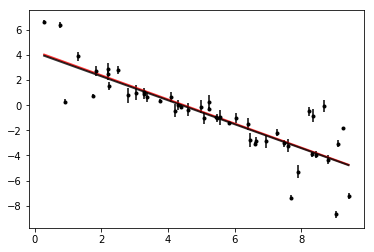

In [28]:
#plotting the data
xl = np.array([0, 10])
plt.plot(x, m_true*x+b_true, color="r", lw=2, alpha=0.8)
plt.plot(x, m_ls*x+b_ls, color="k", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")

In [29]:
#This is not an unreasonable result but the uncertainties on the slope and intercept seem 
#a little small (because of the small error bars on most of the data points)

In [30]:
#Maximum likelihood estimation
#The least squares solution found above is the maximum likelihood result for a model 
#where the error bars are assumed correct, Gaussian and independent. This is not right model.
#we need to write down the likelihood function and numerically optimize it.
#This likelihood function is a Gaussian where the variance is underestimated by some fractional amount
#This code, we will use logarithm of f instead of f because it will force f always positive
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))


In [31]:
#Good way to find numerical optimum of likelihood function is to use the scipy.optimize module
# optimize module minimizes functions whereas we would like to maximize the likelihood. 
#This goal is equivalent to minimizing the negative likelihood (the negative log likelihood)


import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

<ErrorbarContainer object of 3 artists>

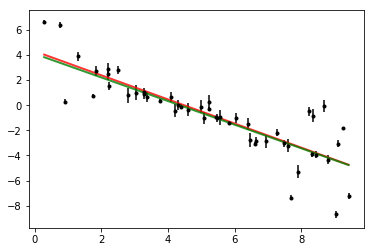

In [32]:
#The maximum likelihood result is plotted as a solid green line—compared to the
#true model(red line) and linear least squares (grey line)

xl = np.array([0, 10])

plt.plot(x, m_true*x+b_true, color="r", lw=2, alpha=0.8)
plt.plot(x, m_ml*x+b_ml, color="g", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")


In [33]:
#The problem now is how do we estimate the uncertainties on m and b? 
# we dont care about the value of f but it seems to propagate any uncertainties 
#about its value to our final estimates of m and b. This is where MCMC comes in.



In [34]:
#Marginalization & uncertainty estimation
#we’ll use uniform (so-called “uninformative”) priors on m, b and the logarithm of f. 
#In code, the log-prior is (up to a constant)

def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [35]:
#combining this with the definition of lnlike from above, the full log-probability function

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [36]:
#After all this setup, it’s easy to sample this distribution using emcee. 
#We’ll start by initializing the walkers in a tiny Gaussian ball around the maximum likelihood result

ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [37]:
#We set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))


In [38]:
sampler.run_mcmc??

In [40]:
#run the MCMC for 500 steps starting from the tiny ball defined above pos, prob, state
sampler.run_mcmc(pos, 500, rstate0=np.random.get_state())
# np.array(trace2)[0].shape
# sampler.reset()

(array([[-0.87905967,  3.77678538, -0.54096775],
        [-0.89332362,  3.73738485, -0.60539129],
        [-0.89260239,  4.04803264, -0.35791153],
        [-0.93357554,  4.0134953 , -0.65843667],
        [-1.02557482,  4.32517427, -0.63573841],
        [-0.80113165,  3.59684365, -0.49217285],
        [-1.05295511,  4.66847741, -0.69160886],
        [-0.93742218,  3.89470435, -0.53521943],
        [-0.96574667,  4.08719967, -0.59399252],
        [-0.93019545,  3.98818675, -0.46414336],
        [-0.92014881,  3.96123271, -0.67242894],
        [-0.89124403,  3.74225887, -0.58672181],
        [-1.03038334,  4.44231205, -0.61006269],
        [-0.91155   ,  3.85085113, -0.75527455],
        [-0.84562354,  3.70915566, -0.59875638],
        [-0.85584681,  3.77510252, -0.40366867],
        [-1.19080535,  5.21004372, -0.72338239],
        [-0.93386396,  3.9560838 , -0.44095441],
        [-0.95302128,  4.02717556, -0.78333705],
        [-0.89794255,  3.9451634 , -0.58150009],
        [-0.9560881 

In [41]:
nwalkers

100

0
1
2


/home/maslinux/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


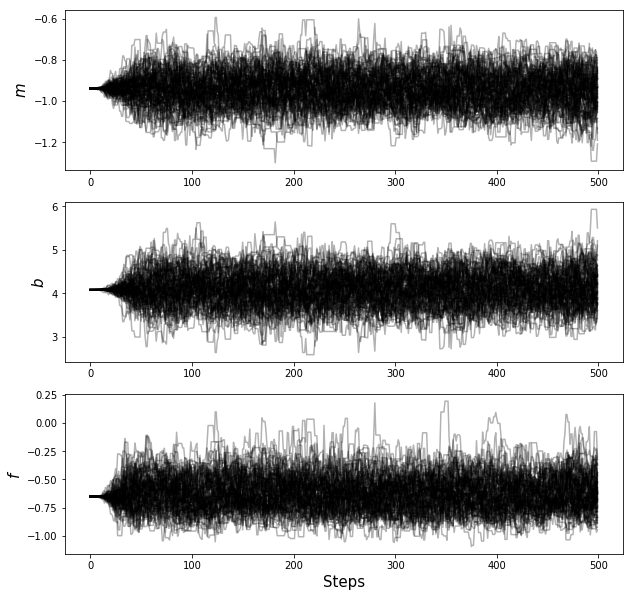

In [42]:
sampler.run_mcmc(pos, 500)
nwalkers = 500
fig = plt.figure(1,figsize=(10, 10))
fig.clf()
for j in range(ndim):
    print(j)
    ax = fig.add_subplot(ndim,1,j+1)
    ax.plot(np.array([sampler.chain[:,i,j] for i in range(nwalkers)]),"k", alpha = 0.3)
#     if j 
#     plt.ylabel(("H0", "O_m")[j], fontsize = 15)

    ax.set_ylabel((r"$m$", r"$b$", r"$f$")[j], fontsize = 15)
plt.xlabel('Steps', fontsize = 15)
fig.show()

In [43]:
#np.array(s)[0].shape

NameError: name 's' is not defined

In [44]:
# pos.shape, prob.shape, #state.shape

In [45]:
# state


In [48]:
#pos.shape

In [49]:
# plt.hist(pos[:,0], bins=20, edgecolor='black')

In [50]:
# # import matplotlib.pyplot as pl
# for i in range(ndim):
#     plt.figure()
#     plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
#     plt.title("Dimension {0:d}".format(i))
#     plt.show()

In [51]:
state


('MT19937', array([1515952309, 1630721553, 4202232737, 2208082897, 1159152940,
        2138083507, 3276733935, 2613534294, 2702212100, 1870828350,
        4176218067, 2398187386, 1252124696, 3454236284, 2087015807,
        2189469988, 3615170282, 4176850747, 3123955158, 2351066081,
        2688202768, 2194919456, 2805539926, 3320641507, 1666737349,
         169305800, 3582698512, 2622655855, 1242474762, 3529461005,
        1253831686, 3576837068, 3823072899,  267587147, 3143443840,
        2632641697, 3418664796,  352493727, 3649331463, 3919889164,
         840710133, 1817370640, 3901976596, 2208767878,  204040171,
         197850690,  134979734, 1683568836, 2426991785, 3251863165,
        3965597004, 2964538469, 1110405122,  749838927,  581734801,
        1413623827, 2801173778, 2444359497, 3124596122, 4033848508,
        3819648237, 2165406260,  273245993,  319911203, 1690105528,
          64801005, 2033515102, 3541409312, 2828567325, 3956241286,
        1788479821, 1168105614, 38935

In [54]:
#m['MT19937']

In [55]:
#plt.plot(np.array(trace2)[0][:,:])

In [57]:
 plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")


IndentationError: unexpected indent (<ipython-input-57-70f694fe8b60>, line 2)

In [58]:
#discard the initial 50 steps and flatten the chain so that we have a flat list of samples

samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

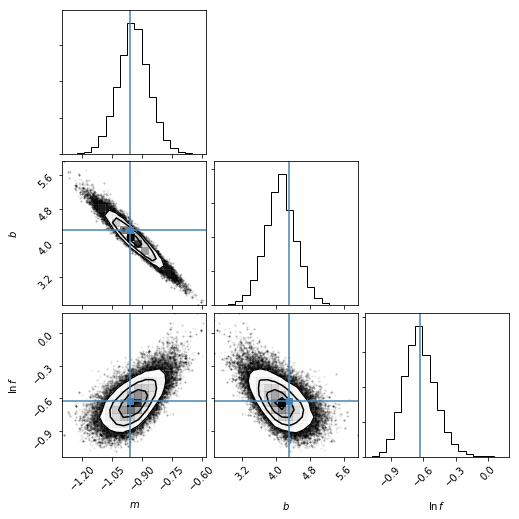

In [59]:
#a corner plot
#most useful plots you can make with MCMC results

import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
#fig.savefig("triangle.png")

In [60]:
#The corner plot shows all the one and two dimensional projections of the posterior probability 
#distributions of your parameters. This is useful because it quickly demonstrates all of the
#covariances between parameters. Also, the way that you find the marginalized distribution 
#for a parameter or set of parameters using the results of the MCMC chain is to project the 
#samples into that plane and then make an N-dimensional histogram. That means that the corner plot shows 
#the marginalized distribution for each parameter independently in the histograms along the diagonal and 
#then the marginalized two dimensional distributions in the other panels.

<ErrorbarContainer object of 3 artists>

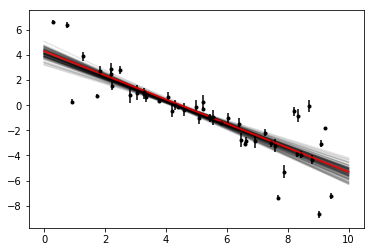

In [61]:
#Another diagnostic plot is the projection of your results into the space of the observed data

import matplotlib.pyplot as pl
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
pl.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
pl.errorbar(x, y, yerr=yerr, fmt=".k")

In [62]:
#This leaves us with one question: which numbers should go in the abstract? There are a few 
#different options for this but my favorite is to quote the uncertainties based on the 16th,
#50th, and 84th percentiles of the samples in the marginalized distributions. To compute 
#these numbers for this example, you would run:


In [63]:
#Compute the numbers
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [64]:
samples

array([[-0.9509354 ,  4.37712238,  0.52128555],
       [-0.93672611,  4.17650344,  0.53137846],
       [-0.93697204,  4.17829081,  0.53219343],
       ...,
       [-0.93754564,  4.01742343,  0.53301589],
       [-0.93754564,  4.01742343,  0.53301589],
       [-0.89080303,  3.84194741,  0.56142034]])